In [62]:
%load_ext autoreload
%autoreload 1
%aimport utils
%aimport utils.path
%aimport utils.backtest
%aimport solvers
%aimport solvers.DRconditionalmeanvariance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import tushare
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import sys
import factors

If we set $\beta$ to be the portfolio allocation, $Y$ be the stock returns and $X$ is the covariate, then the DRO mean-variance model can be written as
$$
    \min_{\beta,\alpha} \sup_{\mathbb Q \in \mathbb B_\rho, \mathbb Q(X = x_0) \geq \epsilon}
    E_{\mathbb Q} [ \ell(Y, \beta, \alpha) | X = x_0]
$$
where the loss function $\ell$ is
$$
    \ell(y, \beta, \alpha) = (y^\top \beta - \alpha)^2 - \eta \cdot y^\top \beta
$$

Suppose that $\epsilon \in (0, 1)$ and $\rho > \rho_{\min}(x_0, \epsilon, 0)$. We have 
$$
f_{\epsilon, \rho}(\beta,\alpha) = \inf_{\substack{\lambda_1\in \mathbf R_+\\ \lambda_2\in\mathbf R}}\left\{
\rho \lambda_1 + \epsilon \lambda_2 + \frac{1}{N} \sum_{i \in [N]} \left( \sup_{y_i} \big\{\epsilon^{-1} \ell(y_i, \beta,\alpha) - [\mathbb D_{\mathcal X}(x_0, \hat x_i) + \mathbb D_{\mathcal Y}(y_i, \hat y_i)] \lambda_1 - \lambda_2 \big\} \right)^+
\right\},
$$
where $(a)^+ = \max\{0, a\}$.

Let $m_i = \sup_{y_i} \big\{\epsilon^{-1} \ell(y_i, \beta,\alpha) - [\mathbb D_{\mathcal X}(x_0, \hat x_i) + \mathbb D_{\mathcal Y}(y_i, \hat y_i)] \lambda_1 - \lambda_2 \big\}$, then we have

$$
m_i = \epsilon^{-1}\cdot 
\frac{(\hat y_i^\top \beta - \alpha-0.5\eta)^2}{1-\epsilon^{-1}\|\beta\|^2/\lambda_1}
-\frac{1}{4}\epsilon^{-1}\eta^2-\epsilon^{-1}\eta\alpha
-\lambda_1\|x_0-\hat x_i\|^2 -\lambda_2
$$

Consider a reformulation:
$$
1-\epsilon^{-1}\|\beta\|^2/\lambda_1 \geq d 
\quad \Longleftrightarrow \quad
1 \geq d + \epsilon^{-1}\|\beta\|^2/\lambda_1
$$
and it follows that 
$$
m_i \leq \epsilon^{-1}\cdot 
\frac{(\hat y_i^\top \beta - \alpha-0.5\eta)^2}{d}
-\frac{1}{4}\epsilon^{-1}\eta^2-\epsilon^{-1}\eta\alpha
-\lambda_1\|x_0-\hat x_i\|^2 -\lambda_2 := m_{\uparrow,i}
$$


## Verification of the closed formed max $m_i$

In [64]:
lambda1 = 100; lambda2 = 5; epsilon = 0.2; d = 10; eta = 2
y_i = np.random.randn(d); beta = np.random.randn(d); alpha = 1
analytical_max_term1 = lambda1*np.square(y_i@beta-alpha-0.5*eta)/(epsilon*lambda1-np.sum(beta**2))
analytical_max_term2 = -0.25*eta**2/epsilon-eta*alpha/epsilon
analytical_max = analytical_max_term1 + analytical_max_term2
print(lambda1-np.sum(beta**2)/epsilon)
def obj(y):
    return (-(y@beta-alpha)**2 + eta*(y@beta))/epsilon + lambda1* np.linalg.norm(y-y_i)**2
import scipy.optimize
res = scipy.optimize.minimize(obj, np.ones(d),tol=1e-4)
print('analytical and numerical max:', analytical_max, -res.fun)

11.3790466014257
analytical and numerical max: 154.38010826157884 154.38010826146365


# introducing an additional parameter $t$

Now we try to reformulate the optimization problem
$$\frac{\epsilon^{-1}\lambda_1}{\lambda_1-\epsilon^{-1}\|\beta\|^2} \leq\epsilon^{-1} + t \quad\rm{for}\quad t >= 0
$$
This implies
$$
\epsilon^{-1}(\epsilon^{-1} + t)\|\beta\|^2 \leq t \lambda_1 
$$
or
$$
\|\beta\|^2 \leq \frac{t}{\epsilon^{-1}(\epsilon^{-1} + t)} \lambda_1 
$$
Given this, 
$$m_i \leq (\epsilon^{-1} + t)(\hat y_i^\top \beta - \alpha-0.5\eta)^2
-\frac{1}{4}\epsilon^{-1}\eta^2-\epsilon^{-1}\eta\alpha
-\lambda_1\|x_0-\hat x_i\|^2 -\lambda_2$$ 
$$s.t.\|\beta\|^2 \leq \frac{t}{\epsilon^{-1}(\epsilon^{-1} + t)} \lambda_1 $$

Therefore, we may solve the optimization problem parameterized by $t$
$$
f_{\epsilon, \rho}(t) =\inf_{\substack{\alpha,\beta}} \inf_{\substack{\lambda_1\in \mathbf R_+\\ \lambda_2\in\mathbf R}}\left\{
\rho \lambda_1 + \epsilon \lambda_2 + \frac{1}{N} \sum_{i \in [N]} \left((\epsilon^{-1} + t)(\hat y_i^\top \beta - \alpha-0.5\eta)^2
-\frac{1}{4}\epsilon^{-1}\eta^2-\epsilon^{-1}\eta\alpha
-\lambda_1\|x_0-\hat x_i\|^2 -\lambda_2\right)^+
\right\},
$$
$$s.t.\|\beta\|^2 \leq \frac{t}{\epsilon^{-1}(\epsilon^{-1} + t)} \lambda_1 $$

In [65]:
sample_stock_num = 20
SZ_code_list = pd.read_pickle('./SZ_code_list.pkl')
SH_code_list = pd.read_pickle('./SH_code_list.pkl')
trading_dates = pd.read_pickle('./trading_dates.pkl')
total_code_list = pd.concat([SZ_code_list, SH_code_list])
total_stock_num = len(total_code_list)
ts_code_generator = np.random.RandomState(42)
sampled_ts_codes = ts_code_generator.choice(total_code_list, size = sample_stock_num, replace = False)
sampled_mean_vec, sampled_cov_mat = utils.debughelper.get_sample_mean_cov(sampled_ts_codes, integer_id = 1000)
info_list = ['pct_chg']
portfolio = utils.preprocess.gen_portfolio_data_table(ts_code_generator, info_list, sample_stock_num)
training_ids = np.where((portfolio['pct_chg'].index >= '2012') & (portfolio['pct_chg'].index < '2017'))[0]
factors_df = utils.datareader.load_fama_french_factors(normalized = True)

In [66]:
X_mat = factors_df['2012':'2013'].values
X0 = factors_df['2014'].iloc[0].values
Y_mat = portfolio['pct_chg']['2012':'2013'].values
X_dist = np.linalg.norm(X_mat - X0, axis = 1)

In [67]:
eta = 1; epsilon = 0.5; epsilon_inv = 1/epsilon;
rho = 1
t = 5; N = Y_mat.shape[0]
c1 = cp.Parameter(nonneg = True)
c2 = cp.Parameter(nonneg = True)
beta = cp.Variable(sample_stock_num)
alpha = cp.Variable(1)
lambda1 = cp.Variable(1, nonneg = True)
lambda2 = cp.Variable(1)
obj = lambda1*rho+lambda2*epsilon + cp.sum(cp.pos(c1*(Y_mat@beta-alpha-0.5*eta)**2 
                                                - 0.25*epsilon_inv*eta**2 
                                                - epsilon_inv*eta*alpha 
                                                - lambda1*X_dist - lambda2)) / N
constraints = [cp.sum_squares(beta) <= c2*lambda1,
              beta >= 0,
              cp.sum(beta) == 1]
prob = cp.Problem(cp.Minimize(obj), constraints)

In [68]:
def obj_val(t):
    c1.value = epsilon_inv + t
    c2.value = t/(epsilon_inv*(epsilon_inv+t))
    return prob.solve()

**Take a look at the dependence of the optimal value on t**

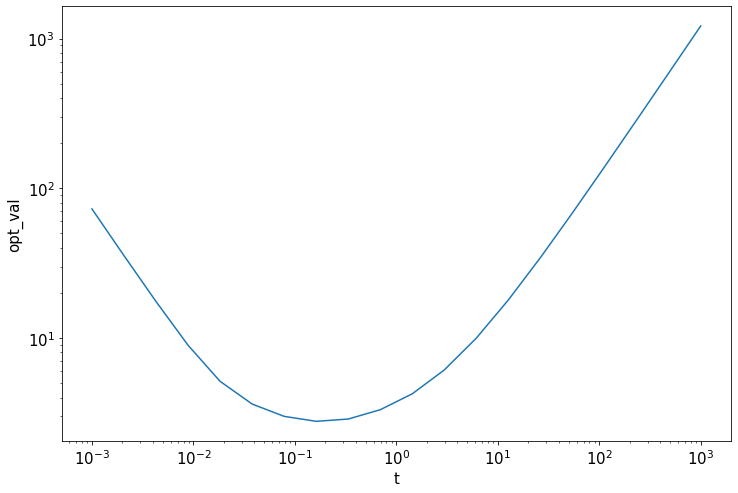

In [69]:
t_array = np.logspace(start=-3,stop=3,num=20,endpoint=True)
optval_array = np.zeros_like(t_array)
for i, t in enumerate(t_array):
    optval_array[i] = obj_val(t)
plt.loglog(t_array, optval_array)
plt.xlabel('t');plt.ylabel('opt_val')
plt.show()

**functions for solving a single DR conditional estimation problem with type-2 Wasserstain transport**

In [95]:
%%timeit
solvers.DRconditionalmeanvariance.DR_W2_conditional_mean_variance_long_only_opt_cvx_kernel(
    X_mat, Y_mat, X0, reg_params = 1, epsilon = 0.2, rho_div_rho_min = 1.1
)

2.22 s ± 37.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
solvers.DRconditionalmeanvariance.DR_W2_conditional_mean_variance_long_only_opt_cvx_kernel_new(
    X_mat, Y_mat, X0, reg_params = 1, epsilon = 0.2, rho_div_rho_min = 1.1
)

1.41 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
utils.backtest.resample_experiments_DR_conditional(exp_num = 50, 
                                                   sample_stock_num = 20, 
                                                   solver = solvers.DRconditionalmeanvariance\
                                                   .DR_W2_conditional_mean_variance_long_only_opt_cvx_kernel, 
                                                   reg_params = 1, 
                                                   epsilon = 0.5, 
                                                   rho_div_rho_min = 1.1)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
time,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.032098,-0.079362,-2.581187,-1.669733,0.715064,-1.899398,-2.284129,-1.283361,-0.749351,-2.792490,...,-3.675813,-2.206464,-3.611726,-1.710423,-1.731054,-2.888286,-1.682429,-1.844127,0.003359,-3.045890
2012-01-05,0.002221,0.000879,1.652383,-1.661587,0.201559,0.042201,-0.413659,0.419744,0.759148,0.293374,...,0.321707,0.155930,1.089889,0.047030,1.183222,0.320307,0.705482,-0.489973,0.000008,0.044368
2012-01-06,0.120663,0.115396,3.797229,1.872265,1.451950,2.550507,4.488546,1.159635,3.095955,1.686151,...,3.187879,2.009757,4.261969,2.885819,2.025798,3.400562,3.893559,0.675061,0.096992,2.870962
2012-01-09,0.121831,0.129178,0.777698,2.083689,0.800062,1.453227,1.637506,0.100732,0.869779,0.905483,...,0.708306,1.227970,1.334541,2.076389,1.197658,0.608943,0.998329,1.007285,-0.016922,2.139209
2012-01-20,-0.049930,-0.012829,-0.174291,-0.409359,-0.738610,-0.616187,0.452191,-0.384565,-0.368371,-0.249831,...,-0.432987,-1.028427,0.206277,0.165140,-0.591178,-0.674168,-0.129555,0.105183,-0.001258,-1.005500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,0.444607,-0.166864,0.490794,1.352778,-0.209027,0.739406,0.051152,0.201033,-0.947114,-0.217432,...,0.117932,-0.256818,0.340672,-0.478231,-0.215298,0.215507,-1.315654,0.327056,0.725337,-0.609611
2016-12-27,-0.348775,1.141544,0.803933,-0.568774,1.558456,-0.640764,-0.533989,-0.484085,0.056316,0.051761,...,-1.287684,-0.591816,-0.346849,-1.748134,-0.263520,-0.168736,-0.173275,-0.355122,0.309453,1.559758
2016-12-28,0.359426,-0.051374,-0.471433,-1.345810,-0.804073,0.048432,0.349308,-0.059018,-1.224465,-0.698716,...,-1.509601,-0.000532,-1.332610,-0.508546,-0.234190,-0.933793,-0.976983,-0.440161,-0.499931,-1.016103


In [80]:
x = cp.Variable(20)
N = x.shape[0]

Expression(CONVEX, NONNEGATIVE, (20, 1))